## Practical Session - Unsupervised Learning

This Practical session is about unsupervised learning. We will use the dimensionality reduction and clustering techniques presented this morning to analyze both toy examples and real images.

Please answer the questions and complete the code where you see (`XXXXXXXXXX`).

First let's load the functions we will use

In [ ]:
import numpy as np
import numpy.matlib
import math
import matplotlib.pyplot as plt
plt.close('all')

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA

from scipy import linalg as LA
from scipy.stats import ortho_group
from scipy.stats import gennorm

from skimage.io import imread
from skimage.transform import resize
from skimage.transform import rescale
from skimage import img_as_bool

from mpl_toolkits.axes_grid1 import AxesGrid
from scipy.spatial.distance import dice
from skimage.measure import find_contours

from scipy.io import loadmat

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# I - Dimensionnality reduction: NMF

## I - 1) Dataset

You will first work on the same face images as during the practical work 1.

Load the original images present in the files *'YaleB\_32x32.mat'*. This is a small part of the freely available Extended Yale Face Database B downloaded from http://www.cad.zju.edu.cn/home/dengcai/Data/FaceData.html. It contains 2414 cropped images resized to 32x32 pixels. Every image is represented as a vector 1x1024 and all images are stacked in a matrix called data. There are 38 subjects with around 64 near frontal images per individual under different illumination conditions. Once loaded and normalised the data, such that the pixels are between 0 and 1, you can plot images using the function *'imshow'*.

**Goal**

The goal of this part is to evaluate the performance of the dimensionality reduction techniques presented this morning for face recognition. We divide the data-set into two parts, training and test. For every dimensionality reduction technique, you will first extract a set of basis images from your training data-set. Then, you will project the test subjects in this new basis and use the nearest neighbor algorithm to evaluate the performance of the dimensionality reduction technique.

Let's load the data and define a function to plot the faces. If you do not remember how the dataset is constituted, please refer to the previous practical work.

In [ ]:
if 'google.colab' in str(get_ipython()):
  from google_drive_downloader import GoogleDriveDownloader as gdd
  gdd.download_file_from_google_drive(file_id='1rgICXtcIAgDqSoHnNXNZMD_iNABF3RZA',
  dest_path='./YaleB_32x32.mat')
else:
  print('You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data')

# Please modify working_dir only if you are using your Anaconda (and not Google Colab)
Working_directory="/content/drive/MyDrive/IMA/IMA205/TP2"




x = loadmat(Working_directory + '/YaleB_32x32.mat')
data=x['fea']
d=data.shape[1] # number of pixels of the images
subjectIndex=x['gnd'] # we have one index per subject
maxValue = np.max(np.max(data)) # max intensity value
data = data/maxValue; # Scale pixels to [0,1]

Ns=len(np.unique(subjectIndex)); # Number subjects
Is=round(len(subjectIndex)/Ns) # Number images per subject (on average, not the same number for every subject)
r=int(np.sqrt(d)) # number rows of each image
c=r # number columns of each image, equal to row since images are square

print('There are', data.shape[0], 'facial images and each image has', d, 'pixels' )
print('There are', Ns, 'different subjects and each subject has on average', Is, 'images')




Xtrain, Xtest, Id_Train, Id_Test = train_test_split(data,subjectIndex,test_size=0.20,stratify=subjectIndex, random_state=44)
Xctest=Xtest-np.mean(Xtest,axis=0) # centering
Xctrain=Xtrain-np.mean(Xtrain,axis=0) # centering



def plotFaces(data,r,c,ncol=2,N=0,indeces=None,title=None):
    # data: each face is a row in data
    # r,c = number of rows and columns of each image
    # n_col = number of columns for subplots
    # N = random images to plot (used only if indeces is empty)
    # indeces = indeces of images to plot
    # title = title of the plot


    if indeces is None:
        if N==0:
            raise NameError('You should define either N or indeces')
        else:
            print('Use N random subjects')
            indeces=np.random.randint(0,data.shape[0],(N,1))

    nrow=math.ceil(len(indeces)/ncol)

    fig=plt.figure(figsize=(17, 6))
    plt.suptitle(title, size=16)
    for i, index in enumerate(indeces):
        fig.add_subplot(nrow, ncol, i+1)
        plt.imshow(np.resize(data[index,:],(r,c)).T,origin='upper',cmap='gray')
        plt.xticks(())
        plt.yticks(())

There are 2414 facial images and each image has 1024 pixels
There are 38 different subjects and each subject has on average 64 images


## I - 2) NNMF

Here you will test Non-negative Matrix factorization. The basis images of the training are in the matrix $W_{train}$ and the scores (or coefficients) to test the performance in $H_{train}$. The test scores are computed as $H_{test}=W_{train}^{-1}X_{test}$.

**Question**

1. Use the scikit-learn implementation to test the performance.



2. Plot the basis images and compare them with respect to the basis images obtained using PCA and ICA in the last practical work. What can you say ?

  Independent components analysis (ICA) assumes that the hidden variables are statistically independent and non-gaussian. Applying ICA to the facial images to make the encodings independent results in basis images that are holistic, i.e. can be explained only by reference to the whole.  

  In PCA, although eigenfaces have a statistical interpretation as the directions of largest variance, many
of them do not have an obvious visual interpretation. This is because PCA allows the entries of the eigenfaces and the encodings to be of arbitrary sign. As the eigenfaces are used in linear combinations that generally
involve complex cancellations between positive and negative numbers, many individual eigenfaces lack intuitive meaning.

  NMF assumes that the hidden variables are non-negative, but makes no further assumptions about their statistical dependencies. The basis images obtained with NNMF presents parts of faces, while the basis images for PCA are ‘eigenfaces’, some of which resemble distorted versions of whole faces. The NMF basis is radically different: its images are localized features that correspond better with intuitive notions of the parts of faces.


3. What about the performances of NNMF, i.e. computational time and classification accuracy ? Is it better or worse than the other methods ? Why ?

  In general, NNMF presents a greater classification accuracy, compared to PCA and ICA. However, NNMF is computationally more expensive.

  NNMF may be a better alternative for image and text classification, since it enforces the non-negativity constraint, extracting features that are more interpretable .

4. Do you think that it is a good idea to use a PCA before the NMF algorithm? Why?

  Use PCA as initiliazation of NMF presents a better recognition rate than applying both methods applied separately, as Lihong Zhao, Guibin Zhuang and Xinhe Xu demonstrated in their paper entitled: "Facial Expression Recognition Based on PCA and NMF". The results demonstrate that NMF and PCA-NMF can outperform PCA.

   These results can be explained by the fact that NMF is sensible to initialization and applying PCA before NMF can reduce the dimensionality of the data while retaining the most important information, being useful when the original data is high-dimensional.





NNMF uses  100  features
Percentage of correct answer using NNMF is  0.8737060041407867


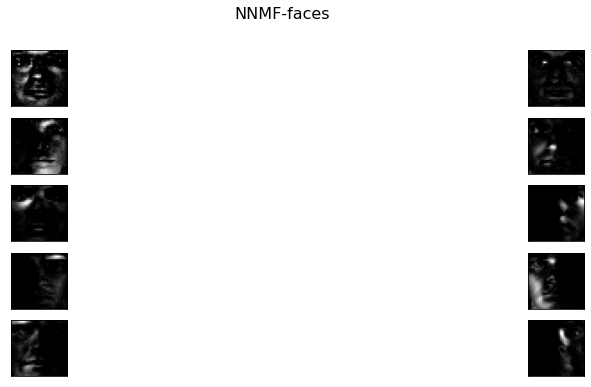

In [ ]:
# NNMF (scikit-learn implementation)
Ncomponents=100
model = NMF(init='random', solver='mu', n_components=Ncomponents, tol=1e-3,max_iter=300, random_state=0)
WtrainNNMF = model.fit_transform(Xtrain.T)
HtrainNNMF = model.components_

plotFaces(WtrainNNMF.T,r,c,ncol=2,indeces=np.arange(0,10,1),title='NNMF-faces')

# to invert the matrix you can use the function LA.pinv
Htest_nnmf = np.dot(LA.pinv(WtrainNNMF),Xtest.T)

print('NNMF uses ', Ncomponents, ' features')

# Score
NN=KNeighborsClassifier(n_neighbors=1)
NN.fit(HtrainNNMF.T,Id_Train.ravel())
print('Percentage of correct answer using NNMF is ', NN.score(Htest_nnmf.T,Id_Test))

Implement your own implementation in `NNMFLecture` following the lecture slides. Complete the missing lines (`XXXXXXXXXX`)

In [ ]:
def NNMFLecture(X,r=None,N_Iter=1000,tolerance=1e-3,plot_evolution=1):
    '''
    Inputs:
    %           X: is a [dxN] matrix. Every column (x) is an observation and every
    %           row consists of features.
    %
    %           r: size of the matrices W and H
    %
    %           (Optional) N_Iter: maximum number of iterations
    %
    %           (Optional) tolerance: convergence criteria threshold
    %
    %           (Optional) plot_evolution: plot evolution convergence criteria
    %
    % Outputs:
    %           W: is a [d x r] matrix containing the basis images in its
    %           columns
    %
    %           H: is a [r x N] matrix containing the loadings (h) in its columns
    %           of the linear combination: x=Wh
    %
  '''
    if r is None:
        r=X.shape[0]

    # Test for positive values
    if np.min(X) < 0:
        raise NameError('Input matrix X has negative values !')

    # Size
    d,N=X.shape

    # Initialization
    W=np.random.rand(d,r)
    H=np.random.rand(r,N)

    # parameters for convergence
    k = 0
    delta = np.inf
    eps=np.finfo(float).eps
    evolutionDelta=[]

    while delta > tolerance and k < N_Iter:

        # multiplicative method
        XH=np.dot(X,H.T)
        HH=np.dot(H,H.T)
        for i in range(20):
          W = np.multiply(W, np.divide(XH, W @ HH + eps))

        H = np.multiply(H, np.divide(W.T @ X, W.T @ W @ H + eps))

        # Convergence indices
        k += 1
        diff=X-np.dot(W,H)
        #delta = np.sqrt(np.sum(diff**2)) / np.sqrt(np.sum(X**2)) # |X-WH|_2 / |X|_2
        delta = LA.norm(diff,'fro') / LA.norm(X,'fro') # sqrt(trace(diff'*diff)) / sqrt(trace(X'*X))
        evolutionDelta.append(delta)

        if k==1 or k%100==0:
            print('Iteration NNMF number ', k, ' out of ', N_Iter , ', delta = ', delta, ', error (norm delta): ', LA.norm(diff))

    if k==N_Iter:
        print('Maximum number of iterations reached ! delta = ', delta)
    else:
        print('Convergence achieved ( delta = ', delta, ') in ', k, ' iterations')

    if plot_evolution==1:
        plt.figure(figsize=(6, 6))
        plt.plot(range(k),evolutionDelta,'bx--', linewidth=4, markersize=12)
        plt.title('Evolution of error - NNMF')
        plt.show()

    return W,H

Iteration NNMF number  1  out of  300 , delta =  0.5314808726298145 , error (norm delta):  273.58343444783276
Iteration NNMF number  100  out of  300 , delta =  0.1587589001705968 , error (norm delta):  81.7222357277284
Iteration NNMF number  200  out of  300 , delta =  0.1511801432113221 , error (norm delta):  77.82101846001318
Iteration NNMF number  300  out of  300 , delta =  0.1486197810874458 , error (norm delta):  76.50305444784803
Maximum number of iterations reached ! delta =  0.1486197810874458


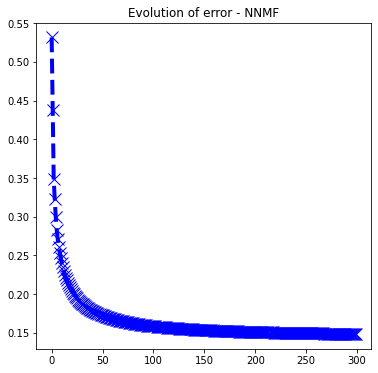

NNMF uses  100  features
Percentage of correct answer using NNMF is  0.8716356107660456


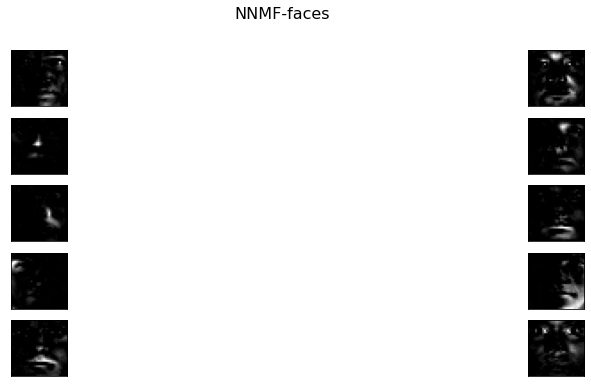

In [ ]:
# NNMF (your own implementation)
Ncomponents=100
Wtrain_nnmf,Htrain_nnmf = NNMFLecture(Xtrain.T,r=Ncomponents,N_Iter=300,tolerance=1e-3,plot_evolution=1)
plotFaces(Wtrain_nnmf.T,r,c,ncol=2,indeces=np.arange(0,10,1),title='NNMF-faces')

# to invert the matrix you can use the function LA.pinv
Htest_nnmf = np.dot(LA.pinv(Wtrain_nnmf),Xtest.T)

print('NNMF uses ', Ncomponents, ' features')

# Score
NN.fit(Htrain_nnmf.T,Id_Train.ravel())
print('Percentage of correct answer using NNMF is ', NN.score(Htest_nnmf.T,Id_Test))

- What do you observe?

  Looking to the basis images, it is possible to observe the extraction of certain features present in our database that can be of interest.

  In addition, the error descreases according to the number of iterations and the NMF presents a percentage of correct answers of 87.37%. This percentage is greater than the PCA using 233 features (70.60%), the KPCA using 1931 features (44.93%), first archictecture of ICA (23.40%) and applying the pixel intensities using 1024 features (72.05%). The only method with percentage of correct answers superior than NMF is the second archictecture of ICA using 1931 features (88.61%).

- What is the limitation of doing an inversion for Htest_nnmf? How would you avoid that?

 The inversion of Htest_nnmf causes a dimensionality problem. To avoid that it is possible to do a transposition of Wtrain_nnmf, however the percentage of correct answers becomes considerably worse.






## I-3) ICA and NNMF in the presence of noise

We will now compare ICA and NNMF results in the presence of noise within the dataset. Please note that during the class on ICA, the dataset $X$ was assumed to be noiseless: we were looking for a decomposition such that $X = AS$, and not $X = AS + N$, where $N$ would be a noise term.

1. How do you think that ICA might behave in the presence of noise? You might in particular consider the case of a Gaussian noise N.

  The independent component analysis (ICA) has the form :

  $ $

  $ X_1 = a_{11}S_1 + a_{12}S_2 + · · · + a_{1p}S_p $

  $ X_2 = a_{21}S_1 + s_{22}S_2 + · · · + a_{2p}S_p $

  .
  .
  .

  $ X_p = a_{p1}S_1 + s_{p2}S_2 + · · · + a_{pp}S_p $

  $ $

  and assumes that the variables $S$ are mutually statistically independent and have unit variance (making the model identifiable up to scaling).

  The assumption of uncorrelation between variables in the PCA is not sufficient to avoid identifiability problems, since given any orthogonal $p × p$ matrix $R$ we have:

  $ $

  $$
  X = AS
  $$

  $$
   = A R^T R S
  $$

  $$
   = A^*S^*
  $$

  $ $

  and $ Cov(S^*) = R \times Cov(S) \times R^T$. As a consequence, there are several possible solutions to the above equation and it is impossible to identify any particular latent variables as unique underlying sources.  

  Lack of correlation, in the PCA method, determines the second-degree cross-moments (covariances) of a multivariate distribution, while the general statistical independence in the ICA determines all of the crossmoments. These extra moment conditions allow us to identify the elements
of A uniquely, solving the identifiability problem.

  Since the multivariate Gaussian distribution is determined by its second moments alone, with the addition of a Gaussian noise it is not possible to assume that the variables are statistically independent anymore, leading to a lack of identifiability.

2. On the other hand, do you think that NNMF behaves better? If so, for what kind of noises?

  NNMF behaves better than ICA in the presence of Gaussian noise because the non-negativity constraint helps to filter out negative noise components but it can still be sensible to other types of noise as impulse noise and high frequency noise.

In the following, we will try to compare the behavior of ICA and NNMF in the presence of noise. Do the following:
- add some Gaussian noise to both the training and the testing dataset.
- apply both NNMF and ICA (the second architecture you implemented in the previous practical work) on the noisy dataset. For both, you can use 250 features.
- use the NN algorithm to classify the images from the features extracted from ICA and NNMF.

Redo the same for different noise levels. Plot a curve of the classification accuracy when either ICA or NNMF are used as pre-processing steps. Comment your results.

In [ ]:
sigmaTab = np.array([0,0.05,0.1,0.15,0.2,0.25,0.3,0.4,0.5])
scoreNMF = np.zeros(len(sigmaTab))
scoreICA = np.zeros(len(sigmaTab))
scoreICA1 = np.zeros(len(sigmaTab))

for i in range(len(sigmaTab)):
    # Data generation
    XtrainNoise = np.clip(Xtrain + np.random.normal(0.5, sigmaTab[i],
                                                    Xtrain.shape), 0, 1)
    XtestNoise = np.clip(Xtest + np.random.normal(0.5, sigmaTab[i],
                                                  Xtest.shape), 0, 1)

    ##################
    # NMF
    Ncomponents=250
    model = NMF(init='random', solver='mu', n_components=Ncomponents, tol=1e-3,max_iter=300, random_state=0)
    WtrainNNMF = model.fit_transform(XtrainNoise.T)
    HtrainNNMF = model.components_

    # to invert the matrix you can use the function LA.pinv
    Htest_nnmf = np.dot(LA.pinv(WtrainNNMF),XtestNoise.T)

    print('NNMF uses ', Ncomponents, ' features')

    # Score
    NN=KNeighborsClassifier(n_neighbors=1)
    NN.fit(HtrainNNMF.T,Id_Train.ravel())
    print('Percentage of correct answer using NNMF is ', NN.score(Htest_nnmf.T,Id_Test))
    scoreNMF[i] = NN.score(Htest_nnmf.T,Id_Test)

    ##################
    ## ICA
    # Second architecture (scikit-learn implementation)
    pca = PCA()
    pca.fit(XtrainNoise)
    U250 = pca.components_[:,0:Ncomponents]
    Y250_train = XtrainNoise @ U250
    Y250_test = XtestNoise @ U250

    ICA = FastICA(n_components=Ncomponents, whiten=True, fun='exp', max_iter=300, tol=1e-3, random_state=1)
    W = ICA.fit_transform(Y250_train.T)
    S = ICA.components_

    NN = KNeighborsClassifier(n_neighbors=1)
    NN.fit((U250 @ W.T @ W @ Y250_train.T).T,Id_Train.ravel())
    print('Percentage of correct answer using ICA is ', NN.score((U250 @ W.T @ W @ Y250_test.T).T,Id_Test.ravel()))
    scoreICA[i] = NN.score((U250 @ W.T @ W @ Y250_test.T).T,Id_Test.ravel())

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn(


NNMF uses  250  features
Percentage of correct answer using NNMF is  0.8716356107660456


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Percentage of correct answer using ICA is  0.7805383022774327


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn(


NNMF uses  250  features
Percentage of correct answer using NNMF is  0.8571428571428571


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Percentage of correct answer using ICA is  0.7287784679089027


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn(


NNMF uses  250  features
Percentage of correct answer using NNMF is  0.8198757763975155


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Percentage of correct answer using ICA is  0.6231884057971014


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn(


NNMF uses  250  features
Percentage of correct answer using NNMF is  0.6873706004140787


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Percentage of correct answer using ICA is  0.474120082815735


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn(


NNMF uses  250  features
Percentage of correct answer using NNMF is  0.5113871635610766


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Percentage of correct answer using ICA is  0.20496894409937888


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn(


NNMF uses  250  features
Percentage of correct answer using NNMF is  0.35403726708074534


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Percentage of correct answer using ICA is  0.21739130434782608


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn(


NNMF uses  250  features
Percentage of correct answer using NNMF is  0.21739130434782608


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Percentage of correct answer using ICA is  0.08902691511387163
NNMF uses  250  features
Percentage of correct answer using NNMF is  0.11387163561076605


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Percentage of correct answer using ICA is  0.09316770186335403
NNMF uses  250  features
Percentage of correct answer using NNMF is  0.08902691511387163


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Percentage of correct answer using ICA is  0.045548654244306416


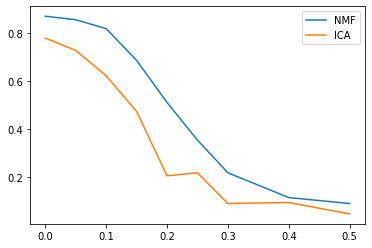

In [ ]:
plt.figure(),plt.plot(sigmaTab,scoreNMF)
plt.plot(sigmaTab,scoreICA)
plt.legend(['NMF','ICA'])

# II - Clustering: K-means

We will now work on the K-means algorithm. First, the K-means algorithm will be used to cluster the toy examples datasets of the first practical work. Then, it will be used to segment real images.

## II - 1) Toy examples

Let us first define the toy examples.

In [ ]:
def generate_scenario(scenario=3, n_samples0 = 100, n_samples1 = 30):

    y = np.concatenate((np.zeros([n_samples0,1]) , np.ones([n_samples1,1])) , axis=0)

    if scenario == 1:
        # Separate Gaussian
        mean0 = [2, 3]
        mean1 = [12, 14]
        cov0 = [[1, 1.5], [1.5 ,3]]
        cov1 = 2 ** 2 * np.eye(2)
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')

    elif scenario == 2:
        # Overlapping Gaussian
        mean0 = [2, 3]
        mean1 = [5, 7]
        cov0 = [[1, 1.5], [1.5 ,3]]
        cov1 = [[2, 3], [3 ,6]]
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')


    elif scenario == 3:
        # Overlapping Gaussian
        mean0 = [0, 0]
        mean1 = [0, 0]
        cov0 = [[50, 15], [15, 6]]#cov0 = [[50, 4], [4, 2]]
        cov1 = [[2, 0], [0 ,50]]#cov1 = [[2, 0], [0 ,50]]
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')


    elif scenario == 4:
        # Circles
        # 1 circle
        angle0=np.linspace(0, 2 * np.pi, n_samples0);
        X0=np.vstack((8*np.cos(angle0) , 8*np.sin(angle0))).T

        # 2 circle
        angle1=np.linspace(0, 2 * np.pi, n_samples1);
        X1=np.vstack((2*np.cos(angle1) , 2*np.sin(angle1))).T

    return X0,X1,y

def plotResults(X0=None,X1=None,y=None,U=None,Y=None,const=1,title=''):

    X=np.concatenate((X0,X1),axis=0)

    N0=np.sum(y==0)
    N1=np.sum(y==1)

    fig=plt.figure(figsize=(17, 6))

    ax  = fig.add_subplot(1, 3, 1)
    plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
    plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
    if U is not None:
        average=X.mean(axis=0)
        sd=LA.norm(X.std(axis=0))
        u0=U[:,0]*const*sd;
        u1=U[:,1]*const*sd;
        plt.plot([average[0]-u0[0], average[0]+u0[0]],[average[1]-u0[1], average[1]+u0[1]], c='g',linewidth=4, label='C 1' )
        plt.plot([average[0]-u1[0], average[0]+u1[0]],[average[1]-u1[1], average[1]+u1[1]], c='k',linewidth=4, label='C 2' )
        plt.title('Original data and components')
    else:
        plt.title('Original data')
    plt.legend()

    ax  = fig.add_subplot(1, 3, 2)
    plt.scatter(Y[np.where(y == 0)[0],0], np.zeros((N0,1)), c='r', s=3, marker='o', label='Class 0')
    plt.scatter(Y[np.where(y == 1)[0],0], np.zeros((N1,1)), c='b', s=3, marker='x', label='Class 1')
    ax.set_title(title + '\n Scores on 1st component')

    ax  = fig.add_subplot(1, 3, 3)
    plt.scatter(Y[np.where(y == 0)[0],1], np.zeros((N0,1)), c='r', s=3, marker='o', label='Class 0')
    plt.scatter(Y[np.where(y == 1)[0],1], np.zeros((N1,1)), c='b', s=3, marker='x', label='Class 1')
    plt.legend()
    plt.title('Scores on 2nd component')

    plt.show()


def frontiere(model, X, y, step=50):

    labels = np.unique(y)

    min_tot = np.min(X)
    max_tot = np.max(X)
    delta = (max_tot - min_tot) / step
    xx, yy = np.meshgrid(np.arange(min_tot, max_tot, delta),
                         np.arange(min_tot, max_tot, delta))
    z = np.array( model.predict(np.c_[xx.ravel(), yy.ravel() ]) )
    z = z.reshape(xx.shape)

    plt.imshow(z, origin='lower', extent=[min_tot, max_tot, min_tot, max_tot],
               interpolation="mitchell", cmap='RdBu')

    cbar = plt.colorbar(ticks=labels)
    cbar.ax.set_yticklabels(labels)

    plt.scatter(X[np.where(yKmeans == 0)[0],0],X[np.where(yKmeans == 0)[0],1],c='r', label='Predicted class 0')
    plt.scatter(X[np.where(yKmeans == 1)[0],0],X[np.where(yKmeans == 1)[0],1],c='b', label='Predicted class 1')

    plt.ylim([min_tot, max_tot])
    plt.xlim([min_tot, max_tot])


Now, create the data we will use.

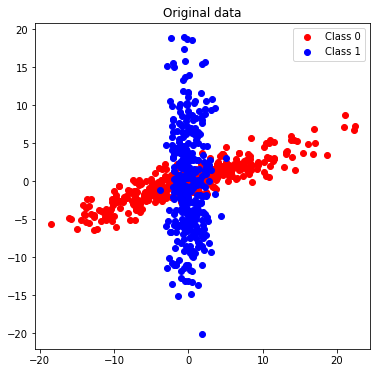

In [ ]:
## Choose the scenarioIndex (value between 1 and 4)
scenarioIndex = 3
##

X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

plt.figure(figsize=(6, 6))
plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()
plt.show()

Use the K-means to find the different clusters in the dataset. K-means will be used on X and we will check whether it can well separate the two classes.


**Question:**
1. Does it work well in all scenarios ? Why ? Is it always easy to define the correct number of clusters ?

  K-means assumes that the data points in each cluster have spherical shape, therefore it may not work well if the data has a different distribution. In addition, depending on the initialization of the cluster centroids, K-means can led to a suboptimal solution if the initialization is poor.

  The determination of the number of clusters can be easy depending on the data. However, in most cases define K is not easy. In this cases, it is possible to apply the elbow method which consists in:
  
  1. Calculate the sum of square distances between points in a cluster and the cluster centroid for each K;
  2. Construte the Elbow Graph with the sum of squares distances (y-axis) corresponding to the differents values of K (x-axis).
  3. Localize the "elbow shape" in the graph and pick the K-value where the elbow gets created.

  In most cases it is not clear to identify the Elbow point in the Graph. In this cases we can apply the Silhouette Coefficient. Using the function SilhouetteVisualizer it is possible to define the optimal K analysing the graph of the silhouette coefficient for each sample on a per-cluster basis.


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


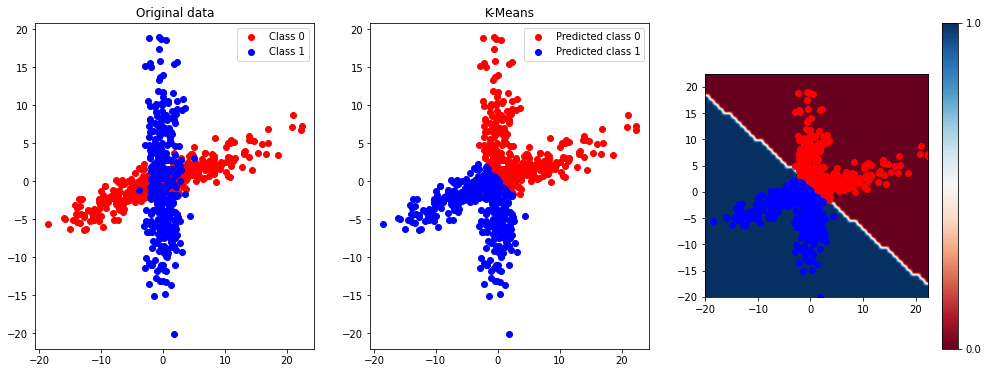

In [ ]:
## K-means
Ncluster= 2 # choose a number of clusters
kmeans=KMeans(n_clusters=Ncluster)
yKmeans=kmeans.fit_predict(X)

plt.figure(figsize=(17, 6))
plt.subplot(131)
plt.scatter(X[np.where(y == 0)[0],0],X[np.where(y == 0)[0],1],c='r', label='Class 0')
plt.scatter(X[np.where(y == 1)[0],0],X[np.where(y == 1)[0],1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()

plt.subplot(132)
plt.scatter(X[np.where(yKmeans == 0)[0],0],X[np.where(yKmeans == 0)[0],1],c='r', label='Predicted class 0')
plt.scatter(X[np.where(yKmeans == 1)[0],0],X[np.where(yKmeans == 1)[0],1],c='b', label='Predicted class 1')
plt.title('K-Means')
plt.legend()

plt.subplot(133)
frontiere(kmeans, X, y, step=50)

plt.show()

Now, implement your own K-means using the Lloyd's algorithm.

In [ ]:
def KMeansLecture(X,K=2,tol=1e-4):
  N = X.shape[0]
  idx = np.random.choice(N, K, replace=False)

  centroids = X[idx,:]
  prev_centroids = np.zeros(centroids.shape)

  while np.linalg.norm(centroids - prev_centroids) >= tol:

    # Optimizes the assignments
    distances = np.array([[np.linalg.norm(X[i,:] - μ, 2) for μ in centroids]
                          for i in range(N)])
    yKmeans = np.argmin(distances, axis=1)
    prev_centroids = centroids

    # Optimizes the μ's
    centroids = []
    for idx in range(K): centroids.append(np.mean(X[yKmeans == idx], axis=0))
    centroids = np.array(centroids)

  return yKmeans,centroids

Now, test your K-means algorithm.

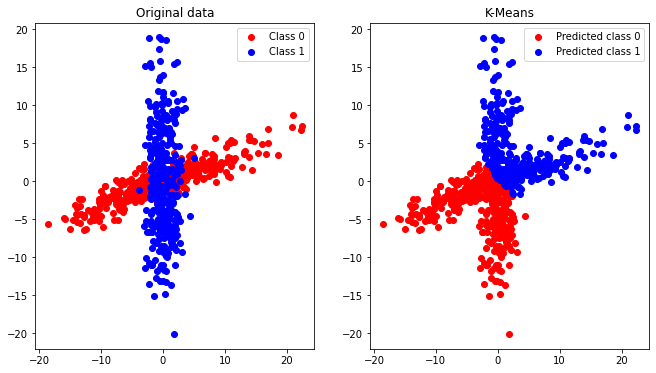

In [ ]:
## K-means
Ncluster= 2 # choose a number of clusters
yKmeans,muTab = KMeansLecture(X,K=Ncluster,tol=1e-4)

plt.figure(figsize=(17, 6))
plt.subplot(131)
plt.scatter(X[np.where(y == 0)[0],0],X[np.where(y == 0)[0],1],c='r', label='Class 0')
plt.scatter(X[np.where(y == 1)[0],0],X[np.where(y == 1)[0],1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()

plt.subplot(132)
plt.scatter(X[np.where(yKmeans == 0)[0],0],X[np.where(yKmeans == 0)[0],1],c='r', label='Predicted class 0')
plt.scatter(X[np.where(yKmeans == 1)[0],0],X[np.where(yKmeans == 1)[0],1],c='b', label='Predicted class 1')
plt.title('K-Means')
plt.legend();

## II-2) K-means for skin lesion segmentation


In this section, you will use the K-means to segment skin lesion images. You will use two images from the ISIC dataset (www.isic-archive.com), one nevus and one melanoma with their respetive manual segmentation.

**Goal**

The goal of this section is to delineate the contours (i.e. segment) of the skin lesions using k-means.

Let's first load the data. The images are rescaled so that the computations are faster.

<ipython-input-5-b35c9cf9b72d>:26: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0. Please use `channel_axis` instead.
  nevus = rescale(nevus, 0.25,multichannel=True, anti_aliasing=True)
<ipython-input-5-b35c9cf9b72d>:37: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0. Please use `channel_axis` instead.
  melanoma = rescale(melanoma, 0.25,multichannel=True, anti_aliasing=True)


(-0.5, 374.5, 280.5, -0.5)

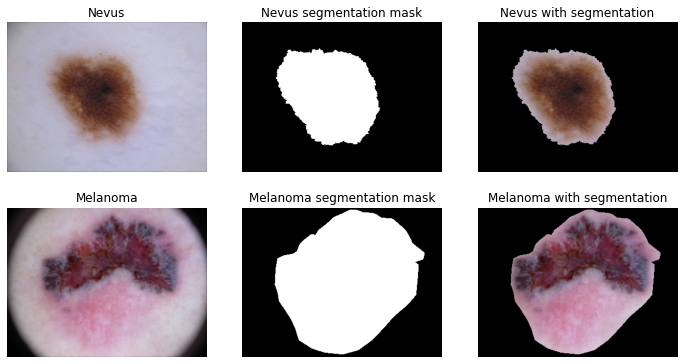

In [ ]:
if 'google.colab' in str(get_ipython()):
  from google_drive_downloader import GoogleDriveDownloader as gdd
  gdd.download_file_from_google_drive(file_id='1_TeYzLLDoKbPX4xXAOAM_mQiT2nLHgvp',
  dest_path='./data/nevus.jpg')
  gdd.download_file_from_google_drive(file_id='1iQZdUiuK_FwZ7mik7LB3eN_H_IUc5l7b',
  dest_path='./data/nevus-seg.jpg')
  gdd.download_file_from_google_drive(file_id='1yZ46UzGhwO7g5T8397JpewBl6UqgRo5J',
  dest_path='./data/melanoma.jpg')
  gdd.download_file_from_google_drive(file_id='1B2Ol92mBcHN6ah3bpoucBbBbHkPMGC8D',
  dest_path='./data/melanoma-seg.png')
else:
  print('You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data')

# Please modify working_dir only if you are using your Anaconda (and not Google Colab)
Working_directory="./data/"




# Nevus
nevus = imread(Working_directory + 'nevus.jpg')
nevus=nevus[2:-2,2:-2,:] # remove border (it contains artifacts)
nevusMask = imread(Working_directory + 'nevus-seg.jpg')
nevusMask=nevusMask[2:-2,2:-2] # remove border (it contains artifacts)
# We rescale to speed up computations
nevus = rescale(nevus, 0.25,multichannel=True, anti_aliasing=True)
# We need all these options to preserve the binary values
nevusMask = rescale(nevusMask, 0.25, anti_aliasing=False, order=0,  preserve_range=True)
nevusMask_boolean = (nevusMask/255).astype(np.uint8) # To get uint8
nevusMask_expand = np.expand_dims(nevusMask_boolean, axis=2) # To have a 3 channels boolean mask

# Melanoma
melanoma = imread(Working_directory + 'melanoma.jpg')
melanoma=melanoma[2:-2,2:-2,:] # remove border (it contains artifacts)
melanomaMask = imread(Working_directory + 'melanoma-seg.png')
melanomaMask=melanomaMask[2:-2,2:-2] # remove border (it contains artifacts)
melanoma = rescale(melanoma, 0.25,multichannel=True, anti_aliasing=True)
melanomaMask = rescale(melanomaMask, 0.25, anti_aliasing=False, order=0,  preserve_range=True)
melanomaMask_boolean = (melanomaMask/255).astype(np.uint8)
melanomaMask_expand = np.expand_dims(melanomaMask_boolean, axis=2)

fig = plt.figure(figsize=(12, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (2, 3),
                axes_pad = 0.5)
grid[0].imshow(nevus)
grid[0].set_title('Nevus')
grid[0].axis('off')
grid[1].imshow(nevusMask_boolean,cmap='gray')
grid[1].set_title('Nevus segmentation mask')
grid[1].axis('off')
grid[2].imshow(nevusMask_expand*nevus)
grid[2].set_title('Nevus with segmentation')
grid[2].axis('off')
grid[3].imshow(melanoma)
grid[3].set_title('Melanoma')
grid[3].axis('off')
grid[4].imshow(melanomaMask_boolean,cmap='gray')
grid[4].set_title('Melanoma segmentation mask')
grid[4].axis('off')
grid[5].imshow(melanomaMask_expand*melanoma)
grid[5].set_title('Melanoma with segmentation')
grid[5].axis('off')



**Questions**

1. Before running K-means, please answer this question. How many classes $K$ should you look for ? Would you use the same $K$ for both images ? Why ?

  The nevus image presents a region of lesion in brown surrounded by a white skin. In this situation a number K = 2 can be sufficient to the correct segmentation.

  The melanoma image presents a lesion more pronounced. In this lesion it is possible to observe a central region in dark red surrounded by some black regions. The skin around this lesion presents some marks in light red. For this image a number K = 3 would be sufficient to segment all lesion.

  Applying the same K for both images would not be a good idea. Applying a K = 2 for both images, for example, would be insufficient to segment all the regions of the melanoma appropriately. On the other hand, applying a K = 3 could result in more regions than necessary in the nevus.

2. Run the following code for both images. Try to choose different channels (among the channels Red, Green and Blue) and different number of clusters $K$. Which is the best choice in terms of channel and number of classes ? You can use the [Dice score](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) to quantitatively compare your mask and the manual segmentation. Comment the results with respect to the previous answer.

  Concerning the best channel for each image, the best channel for the nevus image is the blue channel and for the melanoma image is the red channel, according to their Dice score. The best clusters are K = 2 to the nevus and K = 3 to the melanoma.

The dice score (or dice similarity) between two binary masks is defined as $\frac{2TP}{2TP + FP + FN}$ and it ranges between 0 (completely different) and 1 (perfectly equal).

3. Propose a way to automatically select the class (or unions of classes) representing the skin lesion and not the skin. (You don't need to implement it, just explain how you would do it).

  To the specific case, the easiest way to automatically select the classes is definying a threshold and put the lighter areas in a cluster and the darker in another.

  However, this method will perform poorly for black skin. In this case, it is possible to segment the images analisying its textures. The lesions present a different texture compared to the sking around it. Some method based in Markovian Fields could be a good idea in this situation.

4. In K-means, we recompute the average at each iteration. The average is not constrained to be one of the original observations. It is usually an *interpolation* of the original observations. How would you change the Lloyd's algorithm to constrain the average to always be one of the original observations ?

  It is possible to add a step in which the nearest point to the average will be taken as the actual average.

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The dice score is  0.8298660203325927


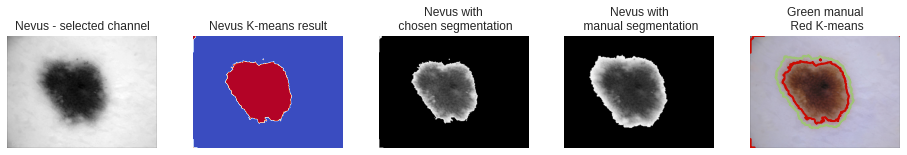

In [ ]:
## NEVUS
# Select a channel (0 for Red, 1 for Green and 2 for Blue)
channel=2
##
nevusB = nevus[:,:,channel]

# Select the number of cluster K to look for
K= 2 # choose a number of clusters
##
kmeans=KMeans(n_clusters=K, random_state=1)
labels=kmeans.fit_predict(nevusB.reshape(-1,1))
labels=np.reshape(labels,(nevusB.shape[0],nevusB.shape[1]))

# Depending on the number of classes K, K-means returns one integer per pixel
# which indicates the number of the cluster.
# Choose the integer to use as mask between 0 and K-1
index =1
mask=labels==index ## choose which label should be

contourMask = find_contours(mask, 0.5)
contourManual = find_contours(nevusMask_boolean, 0.5)

# plot the results
fig = plt.figure(figsize=(16, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 5),
                axes_pad = 0.5)
grid[0].imshow(nevusB,cmap='gray')
grid[0].set_title('Nevus - selected channel')
grid[0].axis('off')
grid[1].imshow(labels,cmap='coolwarm')
grid[1].set_title('Nevus K-means result')
grid[1].axis('off')
grid[2].imshow(mask*nevusB,cmap='gray')
grid[2].set_title('Nevus with\n chosen segmentation')
grid[2].axis('off')
grid[3].imshow(nevusMask_boolean*nevusB,cmap='gray')
grid[3].set_title('Nevus with\n manual segmentation')
grid[3].axis('off')
grid[4].imshow(nevus)
for contour in contourMask:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
for contour in contourManual:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='g')
grid[4].set_title('Green manual\n Red K-means')
grid[4].axis('off')
# Compute the dice score between your mask and the manual segmentation
print('The dice score is ', 1-dice(nevusMask_boolean.reshape(-1,), mask.reshape(-1,)))

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The dice score is  0.5828506199375811


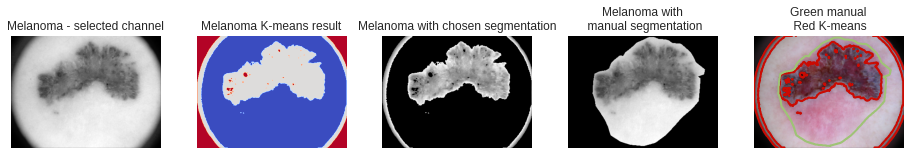

In [ ]:
## MELANOMA
# Select a channel (0 for Red, 1 for Green and 2 for Blue)
channel=0
##
melanomaB = melanoma[:,:,channel]

# Select the number of cluster K to look for
K= 3 # choose a number of clusters
##
kmeans=KMeans(n_clusters=K)
labels=kmeans.fit_predict(melanomaB.reshape(-1,1))
labels=np.reshape(labels,(melanomaB.shape[0],melanomaB.shape[1]))

# Depending on the number of classes K, K-means returns one integer per pixel
# which indicates the number of the cluster.
# Choose the integer to use as mask between 0 and K-1
index =1
mask=labels==index ## choose which label should be

contourMask = find_contours(mask, 0.5)
contourManual = find_contours(melanomaMask_boolean, 0.5)

fig = plt.figure(figsize=(16, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 5),
                axes_pad = 0.5)
grid[0].imshow(melanomaB,cmap='gray')
grid[0].set_title('Melanoma - selected channel')
grid[0].axis('off')
grid[1].imshow(labels,cmap='coolwarm')
grid[1].set_title('Melanoma K-means result')
grid[1].axis('off')
grid[2].imshow(mask*melanomaB,cmap='gray')
grid[2].set_title('Melanoma with chosen segmentation')
grid[2].axis('off')
grid[3].imshow(melanomaMask_boolean*melanomaB,cmap='gray')
grid[3].set_title('Melanoma with\n manual segmentation')
grid[3].axis('off')
grid[4].imshow(melanoma)
for contour in contourMask:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
for contour in contourManual:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='g')
grid[4].set_title('Green manual\n Red K-means')
grid[4].axis('off')

print('The dice score is ', 1-dice(melanomaMask_boolean.reshape(-1,), mask.reshape(-1,)))